In [5]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langgraph.graph import START,END,StateGraph
from langchain.messages import HumanMessage,AIMessage,SystemMessage,ToolMessage
from langgraph.types import Command,Send,RetryPolicy,interrupt
from typing import Literal,TypedDict,List
from langchain_core.prompts import PromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from pydantic import Field,BaseModel
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.runtime import Runtime
import nbformat
from typing import Literal,Dict,List,TypedDict,Optional,Annotated
from pydantic import BaseModel
from pathlib import Path
from nbformat.v4 import new_notebook, new_markdown_cell, new_code_cell
import os
from langchain_groq import ChatGroq
from google.api_core.exceptions import ResourceExhausted
from typing import Any
from dotenv import load_dotenv
load_dotenv()

True

## LLM SERIVICE

In [ ]:
Implement Caching part idea on chat gpt then do OObject oriented and start

In [ ]:
import time,random
class UnifiedRateLimitError(Exception):
    """Raised when an LLM provider hits a rate limit."""
    pass

def call_llm_with_retry(
    llm_call_fn,
    max_retries=3,
    base_delay=1.0,
    max_delay=30.0,
):
    for attempt in range(max_retries):
        try:
            result = llm_call_fn()
            if result is None:
                raise RuntimeError("LLM returned None")
            return result

        except UnifiedRateLimitError:
            if attempt == max_retries - 1:
                raise

            delay = min(
                max_delay,
                base_delay * (2 ** attempt)
            )
            jitter = random.uniform(0, delay * 0.1)

            time.sleep(delay + jitter)
            
def call_gemini(llm, messages, schema=None):
    try:
        if schema is not None:
            llm = llm.with_structured_output(schema)
        return llm.invoke(messages)

    except ResourceExhausted as e:
        raise UnifiedRateLimitError() from e
    
    
LLM_CACHE_TABLE = {
    "table_name": "llm_cache",
    "columns": {
        "cache_key": "TEXT PRIMARY KEY",
        "response_json": "TEXT NOT NULL",
        "created_at": "TIMESTAMP DEFAULT CURRENT_TIMESTAMP"
    }
}

import sqlite3

def create_table_from_schema(conn: sqlite3.Connection, schema: dict):
    cols = ", ".join(
        f"{name} {dtype}"
        for name, dtype in schema["columns"].items()
    )

    sql = f"""
    CREATE TABLE IF NOT EXISTS {schema["table_name"]} (
        {cols}
    );
    """

    conn.execute(sql)
    conn.commit()


def init_cache_db(db_path="llm_cache.db") -> sqlite3.Connection:
    conn = sqlite3.connect(db_path, check_same_thread=False)
    create_table_from_schema(conn, LLM_CACHE_TABLE)
    return conn


import hashlib
import json

def make_cache_key(
    *,
    model_name: str,
    user_prompt: str,
    system_prompt: str,
    output_schema: dict,
    prompt_version: str,
):
    payload = {
        "model": model_name,
        "user": user_prompt,
        "schema": output_schema,
        "prompt_version": prompt_version,
        "system_prompt": system_prompt
    }

    raw = json.dumps(payload, sort_keys=True)
    return hashlib.sha256(raw.encode()).hexdigest()

def cache_get(conn, cache_key: str):
    cur = conn.execute(
        "SELECT response_json FROM llm_cache WHERE cache_key = ?",
        (cache_key,)
    )
    row = cur.fetchone()
    return json.loads(row[0]) if row else None


def cache_set(conn, cache_key: str, value):
    conn.execute(
        """
        INSERT OR REPLACE INTO llm_cache (cache_key, response_json)
        VALUES (?, ?)
        """,
        (cache_key, json.dumps(value))
    )
    conn.commit()
def call_llm_cached(
    *,
    conn,
    llm,
    model_name: str,
    system_prompt: str,
    user_prompt: str,
    output_schema,              # ← Pydantic model (e.g. Cells)
    prompt_version: str,
):
    schema_json = output_schema.model_json_schema()

    cache_key = make_cache_key(
        model_name=model_name,
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        output_schema=schema_json,
        prompt_version=prompt_version,
    )

    cached = cache_get(conn, cache_key)
    if cached is not None:
        return output_schema.model_validate(cached)

    def _call():
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
        return call_gemini(llm, messages, output_schema)

    response = call_llm_with_retry(_call)

    # response is a Pydantic object here
    cache_set(conn, cache_key, response.model_dump())

    return response


## MAIN BRAIN

In [58]:
model = ChatOpenAI(base_url="https://openrouter.ai/api/v1",model="arcee-ai/trinity-mini:free",api_key=os.getenv("OPENROUTER_API_KEY"))
modell = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
model_name = "llama-3.3-70b-versatile"

model = ChatGroq(
    model=model_name
)



In [33]:
system_message = """You are generating notebook cells for a SINGLE lesson in a Jupyter notebook.

You are NOT allowed to decide the structure of the notebook.
You MUST follow the provided CellPlan EXACTLY.

Your task is ONLY to fill in the content of each cell.
"""

user_msg = """You will be given:
1. A LessonMemory object (ground truth)
2. A CellPlan that defines EXACTLY which cells to generate and in what order

You MUST:
- Generate exactly the same number of cells as in the CellPlan
- Match each cell's type (markdown or code) EXACTLY
- Follow the order strictly
- NOT add, remove, merge, or reorder cells

--------------------------------------------------
CELLPLAN (DO NOT MODIFY):
{cell_plan}
--------------------------------------------------

LESSONMEMORY (GROUND TRUTH — DO NOT INVENT):
{lesson_memory}
--------------------------------------------------

GENERAL RULES (MANDATORY):

1. STRUCTURE
- Output MUST be valid JSON that matches this schema:
  {cell_schema}

- Do NOT include explanations outside the JSON
- Do NOT wrap JSON in markdown fences

2. CONCEPT GROUNDING
- You may ONLY use concepts explicitly present in LessonMemory
- Do NOT introduce new concepts, terminology, or topics
- If something is unclear, OMIT it rather than guessing

3. MARKDOWN CELLS
- Use clear pedagogical language
- Include formulas using LaTeX ($ ... $ or $$ ... $$) when applicable
- Do NOT include code blocks in markdown cells unless explicitly asked
- Do NOT include headings that imply lesson structure (e.g., "Lesson Overview")

4. FORMULAS
- All mathematical expressions MUST be written in valid LaTeX
- Prefer display equations ($$ ... $$) for important formulas
- Do NOT include derivations unless explicitly present in LessonMemory

5. CODE CELLS
- Code MUST be valid, runnable Python
- Keep code minimal and focused on the stated purpose
- Do NOT add explanatory comments outside the code
- Do NOT import unnecessary libraries
- Do NOT use external datasets or files

6. MERMAID DIAGRAMS (VERY IMPORTANT)
- Mermaid diagrams MUST appear ONLY inside markdown cells
- Mermaid diagrams MUST be wrapped EXACTLY like this:

```mermaid
graph TD
    A --> B
    B --> C
    
- Mermaid code MUST:

  - span multiple lines

  - use proper indentation

  - NOT be written on a single line

  - NOT include inline explanations

7. CELL CONTENT ONLY

 - Each cell_content MUST contain ONLY the content of that cell

 - Do NOT include markdown fences for the whole cell

 - Do NOT include cell titles like "Cell 1", "Code Cell", etc.

8. FAILURE POLICY

 - If you cannot generate a cell correctly, generate an EMPTY string for its content

 - Do NOT hallucinate to fill missing information

NOW GENERATE THE CELLS.
"""

In [34]:
def build_cell_plan(lesson) -> list[dict]:
    """
    Build a deterministic CellPlan from a LessonMemory object.
    Returns a list of CellPlanItem dicts.
    """
    plan = []
    cell_no = 1


    plan.append({
        "cell_no": cell_no,
        "cell_type": "markdown",
        "purpose": "Explain the core concepts of the lesson"
    })
    cell_no += 1

  
    plan.append({
        "cell_no": cell_no,
        "cell_type": "markdown",
        "purpose": "Explain intuitions and mental models for the lesson"
    })
    cell_no += 1

 
    if lesson.equations:
        plan.append({
            "cell_no": cell_no,
            "cell_type": "markdown",
            "purpose": "Present and explain the key equations used in the lesson"
        })
        cell_no += 1


    for i, primitive in enumerate(lesson.code_primitives):
        plan.append({
            "cell_no": cell_no,
            "cell_type": "code",
            "purpose": f"Implement code primitive: {primitive}"
        })
        cell_no += 1


    for i, visual in enumerate(lesson.visual_primitives):
        plan.append({
            "cell_no": cell_no,
            "cell_type": "markdown",
            "purpose": f"Create a Mermaid diagram: {visual}"
        })
        cell_no += 1

    return plan


# Schema Updated

In [ ]:

class LessonMemory(BaseModel):
    title: str = Field(...,description="Suitable title for this particular lesson.")
    lesson_id: int = Field(
        ...,
        description="Sequential ID of the lesson. Used only for ordering, not explanation."
    )

    key_concepts: List[str] = Field(
        ...,
        description=(
            "Atomic concepts that must be explained explicitly in the notebook. "
            "Each item should be a short noun phrase, not a sentence. "
            "Do not include examples or explanations here."
        )
    )

    intuitions: List[str] = Field(
        ...,
        description=(
            "High-level mental models or intuitions that help understanding. "
            "Write in simple language. Avoid equations and code."
        )
    )

    equations: List[str] = Field(
        ...,
        description=(
            "Core mathematical equations or symbolic expressions that must appear in markdown. "
            "Use LaTeX-style math where appropriate. Skip derivations."
        )
    )

    code_primitives: List[str] = Field(
        ...,
        description=(
            "Concrete code demonstrations that should be implemented in code cells. "
            "Describe the intent of the code, not the full implementation."
        )
    )

    visual_primitives: List[str] = Field(
        default_factory=list,
        description=(
            "Concepts that should be visualized using diagrams (e.g., Mermaid). "
            "Describe what the diagram should convey, not the diagram syntax."
        )
    )

class Week(BaseModel):
    week_id: int = Field(...,description="The week number example 1 for week 1.")# eg: 1 or 2
    week_summary: str = Field(...,description="Summary of the transcription of that particular week.")
    introduced_concepts: List[str] = Field(...,description="What were the new concepts that were introduced in this week if this is not week 1.")
    reinforced_concepts: List[str] = Field(...,description="Concepts that were introduced in earlier weeks or lessons and are "
        "actively reused, applied, or relied upon in this week without being "
        "reintroduced from first principles. These concepts are assumed to be "
        "already understood by the reader and should not be fully re-explained "
        "again. Include a concept here if it appears in equations, code, or "
        "reasoning as a dependency rather than as a new topic.")
class CellFormat(BaseModel):
    cell_type: Literal["code","markdown"] = Field(
        ...,
        description="Final rendered cell type. Must match the corresponding CellPlan."
    )
    purpose: str = Field(...,description="What is title for this cell.(What is happening here in short.)")

    cell_no: int = Field(
        ...,
        description="Cell index local to the lesson. Will be renumbered during notebook assembly."
    )

    cell_content: str = Field(
        ...,
        description=(
            "Complete content of the cell. "
            "Markdown cells may include LaTeX and Mermaid. "
            "Code cells must be valid, runnable Python."
        )
    )  

class Cells(BaseModel):
    cells: List[CellFormat] 
def resettable_add(old: List[str], new: Optional[List[str]]):
    if new is None:
        return []
    return old + new    
from operator import add
class State(TypedDict):
    transcripts_path : str
    path: Dict[int,List[str]]
    current_week: int    
    weeks: Dict[int,Week]   
    lessons: Dict[int,List[LessonMemory]]
    current_week_transcripts: Annotated[List[str],resettable_add] # for getting the transcripts of that particular week
    output_week_material: Annotated[List[str],resettable_add] # for updating the output with the current weeks output. 
    lesson_cells: Dict[int,Dict[int,Cells]]
    current_lesson: int
    notebook_path: str
    conn: Any
    llm : Any
# Use the graph below to make the Parallel executions
    


In [36]:
a = f"Manas{{name}}"
a = a.format(name="Manas")
a

'ManasManas'

In [ ]:
from pydantic import ValidationError
def map_transcripts(state:State) -> State:
    transcripts_path = state["transcripts_path"]
    chapters:List = os.listdir(transcripts_path)
    
    file_paths = {}
    for idx,chapter in enumerate(chapters):
        files = [f"{transcripts_path}/{chapter}/{file.name}"  for file in os.scandir(Path(f"{transcripts_path}/{chapter}"))]
        file_paths[idx+1] = files
        
    return {"path":file_paths}

def route_week(state: State) -> State:
    print("here")
    current_week = state["current_week"]

    transcripts = state["path"][current_week]
    return {"current_week_transcripts":transcripts}

def fan_out_week(state: State):
    weeks = state["weeks"]
    return [
        Send(
            "process_transcript",
            {"transcript": transcript, "current_week": state["current_week"],"t_id":id+1,"weeks":weeks}
        )
        for id,transcript in enumerate(state["current_week_transcripts"])
    ]

def process_transcript(state: State) -> State:
    print(state)
    SYSTEM_PROMPT = """You are an expert in extracting structured learning memory from a single transcript of a lesson. Do it as the user says. Maintain the proper format and see that the content is very much relevant."""
    
    prompt = f"""You are extracting structured learning memory from a single lesson transcript.

        Your task is to convert the provided transcript into a LessonMemory object.
        Focus ONLY on this lesson. Do NOT summarize the entire course or the entire week.

        Guidelines:
        - Extract atomic concepts, not explanations.
        - Separate intuition from equations and code.
        - Do NOT invent content that does not appear in the transcript.
        - Do NOT repeat definitions that are explicitly stated as previously covered.
        - Assume the reader has access to prior weeks' summaries if provided.

        Diagram Rules (IMPORTANT):
        - Generate Mermaid diagrams ONLY when a visual representation significantly improves understanding.
        - Use diagrams for:
        - data flow
        - algorithm steps
        - architectural relationships
        - process pipelines
        - Do NOT create diagrams for simple lists or trivial concepts.
        - Mermaid code must be valid and self-contained.
        - Prefer simple Mermaid types:
        - flowchart
        - sequenceDiagram
        - graph TD

        Output Rules:
        - Return ONLY valid JSON matching the LessonMemory schema.
        - Do NOT include markdown, commentary, or explanations outside the schema.
        - Do NOT generate notebook cells or formatting.

        LessonMemory fields:

        - lesson_id:
        Use the provided lesson_id exactly.

        - week_id:
        Use the provided week_id exactly.

        - title:
        Short descriptive title for this lesson.

        - key_concepts:
        List of atomic concepts introduced or used in this lesson.
        Each item must be a short noun phrase (2-5 words).
        Do NOT include explanations, examples, or verbs.

        - intuitions:
        High-level mental models that help understanding.
        Use simple language.
        Avoid equations, symbols, or code.

        - equations:
        Core mathematical expressions that appear in the lesson.
        Use LaTeX-style math when appropriate.
        Skip derivations.

        - code_primitives:
        Describe concrete coding demonstrations or implementations shown or discussed.
        Focus on intent, not full code.

        - visual_primitives:
        A list of Mermaid diagram definitions as strings.
        Each item must contain ONLY valid Mermaid syntax.
        Do NOT wrap diagrams in markdown code fences.
        Do NOT include explanations or comments.

        RULES:
        1. Limit key_concepts to the 8-12 most important concepts for this lesson.
        If more concepts appear, prioritize those that are central to learning objectives.
        2. Do NOT include:
            - historical anecdotes
            - personal advice
            - meta commentary
        unless they introduce a technical concept.
        
        Context from previous weeks (if any):
        {{previous_week_context}}

        Lesson transcript:
        {{lesson_transcript}}
        """
    transcript = state["transcript"]
    week = state["current_week"]
    t_id = state["t_id"]
    with open(transcript,"r") as f:
        content = f.read()
        
    if week == 1:
        week_context = None
    else:
        prev_weeks_content = state["weeks"]
        last_week : Week = prev_weeks_content[week-1]
        week_context = f"""
        Week {week} Summary:

        Previously introduced concepts:
        {last_week.introduced_concepts}

        Concepts reinforced in the previous week:
        {last_week.reinforced_concepts}

        Assumptions for this lesson:
        - The reader already understands the above concepts.
        - Do NOT re-explain them from first principles.
        - Only reference them briefly if needed to support new ideas.
        """
    prompt = prompt.format(previous_week_context=week_context,lesson_transcript=content)
    
    result : LessonMemory = call_llm_cached(
    conn=state["conn"],
    llm=state["llm"],
    model_name="gemini-2.5-flash",
    system_prompt=SYSTEM_PROMPT,
    user_prompt=prompt,
    output_schema=LessonMemory,        
    prompt_version="process_transcript_v1",
    )   

    result.lesson_id = t_id
    # result = {"title":1,"lessson_id":1,"key_concepts":["something"],"intuitions":["some"],"equations":["aa"],"code_primitives":["assa"]}
    print(result)
    return {"output_week_material":[result]}

def compile_for_a_week(state:State):
    current_week = state["current_week"]
    output_curr_week = state["output_week_material"]
    output = state["lessons"]
    output[current_week] = output_curr_week
    return {
        "lessons": output,"output_week_material":None,"current_week_transcripts":None
    }


def summary_week(state:State) ->State:
    SYSTEM_PROMPT = """You are an expert in aggregating content. Your task is to analyze the provided data for each lesson of for this week and
    produce a single Week object."""
    prompt = """You are aggregating structured learning content for ONE week of a course.
    
            Your task is to analyze the provided data for each lesson for this week and
            produce a single Week object.

            Focus ONLY on this week.
            Do NOT summarize the entire course.
            Do NOT include lesson-level details.

            Guidelines:
            - Consolidate ideas across lessons.
            - Remove redundancy between lessons.
            - Emphasize conceptual progression within the week.
            - Assume the reader will study lessons in order.

            Concept Classification Rules (VERY IMPORTANT):

            - Introduced concepts:
            Concepts that appear for the FIRST time in this week and are explained or
            defined as new ideas.
            Do NOT include concepts that were introduced in earlier weeks.

            - Reinforced concepts:
            Concepts that were introduced in earlier weeks but are actively reused,
            applied, or relied upon in this week.
            These concepts are NOT reintroduced from first principles in this week.

            - If a concept appears in both prior context and this week:
            - Include it ONLY in reinforced_concepts
            - Do NOT include it in introduced_concepts

            - Do NOT include extremely generic concepts (e.g., "Neural Network",
            "Deep Learning") unless they are the primary focus of the week.

            Week Summary Rules:
            - Write a concise, high-level summary (1-2 short paragraphs).
            - Describe what the learner achieves by the end of the week.
            - Avoid lesson-by-lesson narration.
            - Avoid equations and code.

            Output Rules:
            - Return ONLY valid JSON matching the Week schema.
            - Do NOT include markdown, explanations, or commentary outside the schema.

            Week fields:

            - week_id:
            Use the provided week_id exactly.

            - week_summary:
            A high-level summary of what this week teaches and how the lessons connect.

            - introduced_concepts:
            A list of new concepts introduced in this week.
            Use short noun phrases.
            Limit to the most important concepts only.

            - reinforced_concepts:
            A list of previously introduced concepts that are reused or relied upon
            in this week without full re-explanation.

            Context from previous weeks (if any):
            {{previous_week_context}}

            LessonMemory objects for this week:
            {{lesson_memories}}
            """
    week = state["current_week"]
    if week == 1:
        week_context = None
    else:
        prev_weeks_content = state["weeks"]
        last_week : Week = prev_weeks_content[week-1]
        week_context = f"""
        Week {week-1} Summary:

        Previously introduced concepts:
        {last_week.introduced_concepts}

        Concepts reinforced in the previous week:
        {last_week.reinforced_concepts}

        Assumptions for this lesson:
        - The reader already understands the above concepts.
        - Do NOT re-explain them from first principles.
        - Only reference them briefly if needed to support new ideas.
        """
    lesson_memories_: LessonMemory = state["lessons"][week]
    updated_lesson_memories = [{"lesson_id":item.lesson_id,"key_concepts":item.key_concepts,"intuitions":item.intuitions} for item in lesson_memories_]
    print(updated_lesson_memories)
    prompt = prompt.format(previous_week_context=week_context,lesson_memories_=updated_lesson_memories)
    
    result : Week = call_llm_cached(
    conn=state["conn"],
    llm=state["llm"],
    model_name="gemini-2.5-flash",
    system_prompt=SYSTEM_PROMPT,
    user_prompt=prompt,
    output_schema=Week,        
    prompt_version="process_week_v1",
    )   
    
    
    
    result.week_id = state["current_week"]
    print(result)
    curr_week_summary = state["weeks"]
    curr_week_summary[state["current_week"]] = result

    return {"weeks":curr_week_summary}
    # getting error while accessing lessons key maybe have to add a empty node just after the processing node.
    
def advance_week(state: State) -> Command[Literal["route_cell","route_week"]]:
    current_week = state["current_week"]
    print(len(state["path"]) == current_week)
    if current_week == len(state["path"]):
        print("Here")
        return Command(update={"current_week":1},goto="route_cell")
    else:
        print("looping")
        return Command(goto="route_week",update={"current_week": state["current_week"] + 1})
 
def route_cell(state: State) -> State:
    print("here to route cell")
    current_week = state["current_week"]

    lessonMemoryT = state["lessons"][current_week]
    return {"current_week_transcripts":lessonMemoryT}

def fan_out_cell(state: State):

    return [
        Send(
            "cell_generation",
            {"lesson_memory": lessonMemoryT, "current_week": state["current_week"],"t_id":id+1}
        )
        for id,lessonMemoryT in enumerate(state["current_week_transcripts"])
    ]
 
   
def cell_generation(state:State) -> State:
    lesson = state["lesson_memory"]
    plan = build_cell_plan(lesson)
    cell_format = """{
    "cells": [
      {
        "cell_type": "markdown" | "code",
        "purpose": "<string>",
        "cell_no": <integer>,
        "cell_content": "<string>"
      }
    ]
    }"""
    lesson_id = state["t_id"]
    user_msg = user_msg.format(cell_plan=plan,lesson_memory=lesson,cell_schema=cell_format)
    result : CellFormat = call_llm_cached(
    conn=state["conn"],
    llm=state["llm"],
    model_name="gemini-2.5-flash",
    system_prompt=system_message,
    user_prompt=user_msg,
    output_schema=CellFormat,        
    prompt_version="process_cell_v1",
    )   
    
    current_week = state["current_week"]
  
    return {"current_lesson":lesson_id,"lesson_cells":{current_week:{lesson_id:result}}}
    

 
def advance_cells_week(state: State) -> Command[Literal["build_and_save_notebook","route_cell"]]:
    current_week = state["current_week"]
    print(len(state["lessons"]) == current_week)
    if current_week == len(state["lessons"]):
        print("Here")
        return Command(update={"current_week":1},goto="build_and_save_notebook")
    else:
        print("looping")
        return Command(goto="route_cell",update={"current_week": state["current_week"] + 1})
    
def build_and_save_notebook(state):
    """
    LangGraph node that:
    1. Builds a Jupyter notebook from lesson_cells
    2. Writes it to disk as a .ipynb file

    Expects in state:
        state["lesson_cells"]: Dict[int, Dict[int, Cells]]

    Returns:
        {
            "notebook_path": str
        }
    """

    lesson_cells: Dict[int, Dict[int, Cells]] = state["lesson_cells"]

    # Create empty notebook
    nb = new_notebook(cells=[])

    # Assemble notebook content
    for week_id in sorted(lesson_cells.keys()):
        # Week header
        nb.cells.append(
            new_markdown_cell(f"# Week {week_id}")
        )

        lessons_in_week = lesson_cells[week_id]

        for lesson_id in sorted(lessons_in_week.keys()):
            # Lesson header
            nb.cells.append(
                new_markdown_cell(f"## Lesson {lesson_id}")
            )

            cells_obj = lessons_in_week[lesson_id]

            # Sort cells by local cell_no
            sorted_cells = sorted(
                cells_obj.cells,
                key=lambda c: c.cell_no
            )

            for cell in sorted_cells:
                # Optional: include purpose as a short heading
                if cell.purpose:
                    nb.cells.append(
                        new_markdown_cell(f"**{cell.purpose}**")
                    )

                if cell.cell_type == "markdown":
                    nb.cells.append(
                        new_markdown_cell(cell.cell_content)
                    )

                elif cell.cell_type == "code":
                    nb.cells.append(
                        new_code_cell(cell.cell_content)
                    )

                else:
                    raise ValueError(f"Unknown cell_type: {cell.cell_type}")

    # -----------------------------
    # Write notebook to disk
    # -----------------------------

    output_dir = Path("generated_notebooks")
    output_dir.mkdir(parents=True, exist_ok=True)

    notebook_path = output_dir / "course_notes.ipynb"

    nbformat.write(nb, notebook_path)

    return {
        "notebook_path": str(notebook_path)
    }

# looping issue the state gets updated while creating the send objects I have added the weeks field again during send but did not check please check if it works or not.

In [53]:
lst = [{"name":"Manas","age":18},{"name":"Manaadas","age":181},{"name":"Manaads","age":98}]

[{"name": item["name"]} for item in lst]

[{'name': 'Manas'}, {'name': 'Manaadas'}, {'name': 'Manaads'}]

In [54]:
workflow = StateGraph(state_schema=State)
workflow.add_node("map_transcripts",map_transcripts)
workflow.add_node("route_week",route_week)
workflow.add_node("fan_out_week",fan_out_week)
workflow.add_node("process_transcript",process_transcript)
workflow.add_node("compile_for_a_week",compile_for_a_week)
workflow.add_edge("map_transcripts", "route_week")
workflow.add_node("summary_week",summary_week)
workflow.add_node("advance_week", advance_week)
workflow.add_node("route_cell",route_cell)
workflow.add_node("fan_out_cell",fan_out_cell)
workflow.add_node("cell_generation",cell_generation)

workflow.add_node("advance_cells_week",advance_cells_week)
workflow.add_node("build_and_save_notebook",build_and_save_notebook)
workflow.add_edge(START,"map_transcripts")
workflow.add_conditional_edges("route_week", fan_out_week, ["process_transcript"])
workflow.add_edge("process_transcript","compile_for_a_week")
workflow.add_edge("compile_for_a_week","summary_week")
workflow.add_edge("summary_week","advance_week")
workflow.add_conditional_edges("route_cell", fan_out_cell, ["cell_generation"])
workflow.add_edge("cell_generation","advance_cells_week")

graph = workflow.compile()

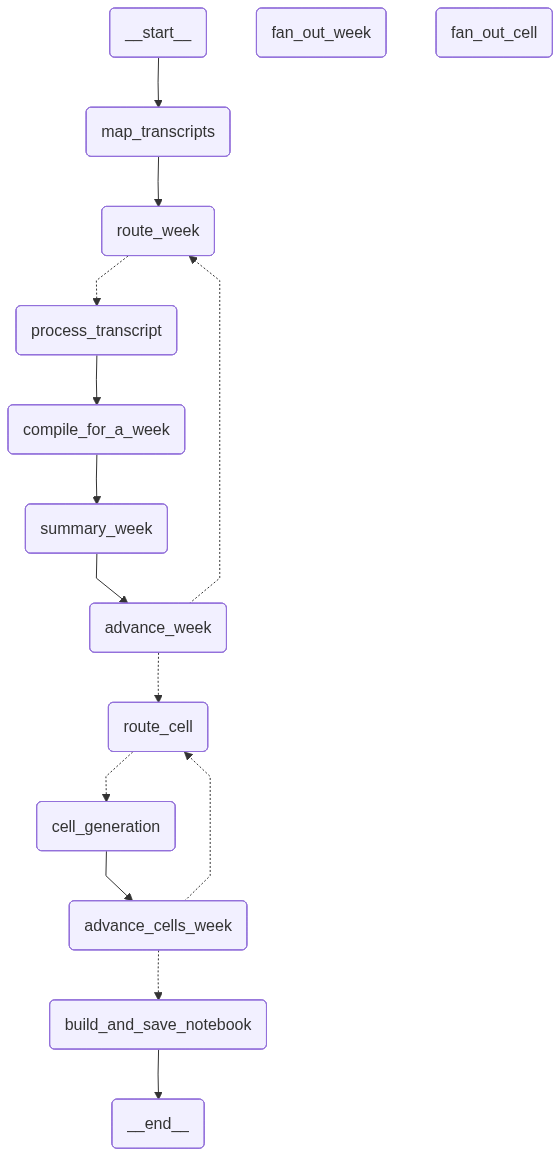

In [55]:
graph

In [10]:
graph.invoke({"transcripts_path":"./transcripts","current_week":1,"lessons":{},"weeks":{}})

here
{'transcript': './transcripts/1.Introduction_to_deep_learning/01-welcome.txt', 'current_week': 1, 't_id': 1, 'weeks': {}}
{'transcript': './transcripts/1.Introduction_to_deep_learning/02-what-is-a-neural-network.txt', 'current_week': 1, 't_id': 2, 'weeks': {}}
{'transcript': './transcripts/1.Introduction_to_deep_learning/03-supervised-learning-with-neural-networks.txt', 'current_week': 1, 't_id': 3, 'weeks': {}}
{'transcript': './transcripts/1.Introduction_to_deep_learning/04-why-is-deep-learning-taking-off.txt', 'current_week': 1, 't_id': 4, 'weeks': {}}
{'transcript': './transcripts/1.Introduction_to_deep_learning/05-about-this-course.txt', 'current_week': 1, 't_id': 5, 'weeks': {}}
{'transcript': './transcripts/1.Introduction_to_deep_learning/06-geoffrey-hinton-interview.txt', 'current_week': 1, 't_id': 6, 'weeks': {}}
title='Introduction to Deep Learning' lesson_id=5 key_concepts=['Deep Learning', 'Neural Network', 'Forward Propagation', 'Back Propagation', 'Neural Network Pro

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01k319wsq2esaav2s222kab99e` service tier `on_demand` on tokens per minute (TPM): Limit 12000, Used 10183, Requested 1895. Please try again in 389.999999ms. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [7]:
path = Path("./transcripts")
os.listdir(path)

['1.Introduction_to_deep_learning',
 '2.Neural_networks_basics',
 '3.Shallow_neural_networks',
 '4.Deep_neural_networks']

In [18]:
chapters = os.listdir(path)
file_paths = {}
for idx,chapter in enumerate(chapters):
    files = [f"{path}/{chapter}/{file.name}" for file in os.scandir(Path(f"{path}/{chapter}"))]
    file_paths[idx+1] = files

In [19]:
file_paths

{1: ['transcripts/1.Introduction_to_deep_learning/01-welcome.txt',
  'transcripts/1.Introduction_to_deep_learning/02-what-is-a-neural-network.txt',
  'transcripts/1.Introduction_to_deep_learning/03-supervised-learning-with-neural-networks.txt',
  'transcripts/1.Introduction_to_deep_learning/04-why-is-deep-learning-taking-off.txt',
  'transcripts/1.Introduction_to_deep_learning/05-about-this-course.txt',
  'transcripts/1.Introduction_to_deep_learning/06-geoffrey-hinton-interview.txt'],
 2: ['transcripts/2.Neural_networks_basics/01-binary-classification.txt',
  'transcripts/2.Neural_networks_basics/02-logistic-regression.txt',
  'transcripts/2.Neural_networks_basics/03-logistic-regression-cost-function.txt',
  'transcripts/2.Neural_networks_basics/04-gradient-descent.txt',
  'transcripts/2.Neural_networks_basics/05-derivatives.txt',
  'transcripts/2.Neural_networks_basics/06-more-derivative-examples.txt',
  'transcripts/2.Neural_networks_basics/07-computation-graph.txt',
  'transcripts/2

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send,Command
from typing_extensions import TypedDict, Annotated,Dict,List,Optional
import operator
def resettable_add(old: List[str], new: Optional[List[str]]):
    if new is None:
        return []
    return old + new

class OverallState(TypedDict):
    current_week: int
    all_items: Dict[int, List[str]]
    output: Dict[int, Annotated[List[str], operator.add]]
    current_jokes: Annotated[List[str],resettable_add]
    output_jokes: Annotated[List[str],resettable_add]
    
   
def generate_topics(state: OverallState):
    joke_map = {
        1: ["Why don't lions like fast food? Because they can't catch it!", "hello"],
        2: ["Why don't elephants use computers? They're afraid of the mouse!", "Hi"],
        3: ["Why don't penguins like talking to strangers at parties? Because they find it hard to break the ice.", "Namaste"]
    }
    return {
        "all_items": joke_map,
        "current_week": 1,
        "output": {}
    }


def route_week(state: OverallState) -> Command[Literal["fan_out_week"]] :
    print("here")
    current_week = state["current_week"]

    jokes = state["all_items"][current_week]
    return {"current_jokes": jokes}
    

def fan_out_week(state: OverallState) -> Command[Literal["process_joke"]]:
    return [
        Send(
            "process_joke",
            {"joke": joke, "current_week": state["current_week"]}
        )
        for joke in state["current_jokes"]
    ]
    
def process_joke(state: OverallState):
    joke = state["joke"].upper()
    week = state["current_week"]

    return {
        "output_jokes":[joke]
    }
def compile_for_next(state:OverallState):
    current_week = state["current_week"]
    jokes_curr_week = state["output_jokes"]
    output = state["output"]
    output[current_week] = jokes_curr_week
    return {
        "output": output,"output_jokes":None,"current_jokes":None
    }
def advance_week(state: OverallState) -> Command[Literal[END,"route_week"]]:
    current_week = state["current_week"]
    print(len(state["all_items"]) == current_week)
    if current_week == len(state["all_items"]):
        print("Here")
        return Command(goto=END)
    else:
        print("looping")
        return Command(goto="route_week",update={"current_week": state["current_week"] + 1})

builder = StateGraph(OverallState)

builder.add_node("generate_topics", generate_topics)
builder.add_node("route_week", route_week)
builder.add_node("fan_out_week", fan_out_week)
builder.add_node("process_joke", process_joke)
builder.add_node("advance_week", advance_week)
builder.add_node("compile_for_next", compile_for_next)
builder.add_edge(START, "generate_topics")
builder.add_edge("generate_topics", "route_week")


builder.add_conditional_edges("route_week", fan_out_week, ["process_joke"])

builder.add_edge("process_joke", "compile_for_next")
builder.add_edge("compile_for_next","advance_week")


graph = builder.compile()


ValueError: Found edge ending at unknown node `fan_out_week`

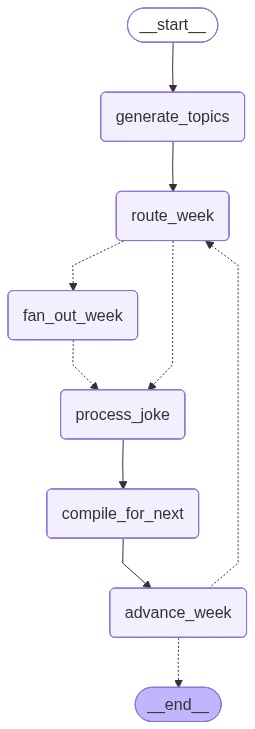

In [32]:
graph

In [30]:
graph.invoke({"current_week":1,"all_items":{}})

here
False
looping
here
False
looping
here
True
Here


{'current_week': 3,
 'all_items': {1: ["Why don't lions like fast food? Because they can't catch it!",
   'hello'],
  2: ["Why don't elephants use computers? They're afraid of the mouse!", 'Hi'],
  3: ["Why don't penguins like talking to strangers at parties? Because they find it hard to break the ice.",
   'Namaste']},
 'output': {1: ["WHY DON'T LIONS LIKE FAST FOOD? BECAUSE THEY CAN'T CATCH IT!",
   'HELLO'],
  2: ["WHY DON'T ELEPHANTS USE COMPUTERS? THEY'RE AFRAID OF THE MOUSE!", 'HI'],
  3: ["WHY DON'T PENGUINS LIKE TALKING TO STRANGERS AT PARTIES? BECAUSE THEY FIND IT HARD TO BREAK THE ICE.",
   'NAMASTE']},
 'current_jokes': [],
 'output_jokes': []}